In [1]:
import math
import datetime
import os, sys
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from IPython.display import Audio
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary

import cv2




# local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition
import training

In [2]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment =  pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) # or choose # DummyEnvironment()


# Model parameters
BATCH_SIZE = 128 #original 128
GAMMA = 0.1 # 0.999
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY_steps = 4000 
EPS_DECAY = (EPS_START - EPS_END)/EPS_DECAY_steps
REPLAY_START_SIZE =  1500
TARGET_UPDATE = 10 #episodes
DEVICE = 'cuda:0'
MEMORY_CAPACITY = 12000

# agent = model.DoubleDQNAgent(imsize=IMSIZE, 
#                  in_channels=STACK_SIZE,
#                  n_actions=N_ACTIONS,
#                  memory_capacity=MEMORY_CAPACITY,
#                  eps_start=EPS_START,
#                  eps_end=EPS_END,
#                  eps_delta=EPS_DECAY,
#                  gamma_discount = GAMMA,
#                  batch_size = BATCH_SIZE,
#                  device=DEVICE)


# Optimizer Parameters
LR_DQN = 0.0001 # 0.01

# optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

In [3]:
# Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):
        """ @TODO 
        - Extended image processing
        """
        self.imsize = imsize
        if phosphene_resolution is not None:
            self.simulator = utils.PhospheneSimulator(phosphene_resolution=(phosphene_resolution,phosphene_resolution),
                                                     size=(128,128),
                                                     jitter=0.25,
                                                     intensity_var=0.9,
                                                     aperture=.66,
                                                     sigma=0.60,)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw,):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
        if self.simulator is not None:
            frame = self.simulator(frame)
    
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize)



In [4]:
## Training parameters 
MAX_EPISODES = 800 # number of episodes (an episode ends after agent hits a box)
MAX_STEPS  = 5e4  # number of optimization steps (each time step the model parameters are updated)
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:True,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Training configuration dictionary
cfg = dict()
# cfg['seed']                     = SEED
# cfg['training_condition']       = TRAINING_CONDITION 
cfg['max_episodes']             = MAX_EPISODES
# cfg['model_path']               = MODEL_PATH
cfg['max_steps']                = MAX_STEPS
cfg['target_update']            = TARGET_UPDATE
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL
cfg['replay_start_size']        = REPLAY_START_SIZE
# cfg['logfile']                  = LOGFILE

# for seed in [0,1,2,3,4]:
#     for complexity in ['plain', 'complex']:
#         for phosphene_resolution in [None, 50,42,34,26,18,10]:

seed = 0
phosphene_resolution = None
complexity = 'plain'

for GAMMA in [0.9, 0.99, 0.999]:
    for LR_DQN in [0.002,0.01,0.03]:

        # Condition-specific configuration
        cfg['training_condition'] = 0 if complexity == 'plain' else 1 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
        cfg['seed'] = seed
        torch.manual_seed(seed)
        model_name = 'exp1_{}_phos{}_S{}_LR{}_gamma{}'.format(complexity,phosphene_resolution,seed,LR_DQN,GAMMA)
        model_name = model_name.replace('.', '')
        model_name = model_name.replace('+', '')
        model_name = model_name.replace(',', '')
        print(model_name)
        cfg['logfile'] = 'Out/Exp1/{}_train_stats.csv'.format(model_name)
        cfg['model_path'] = 'Out/Exp1/{}_best_model.pth'.format(model_name)

        # Phosphene simulation
        img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)

        # Re-initialize model and optimizer
        agent = model.DoubleDQNAgent(imsize=IMSIZE,
             in_channels=STACK_SIZE,
             n_actions=N_ACTIONS,
             memory_capacity=MEMORY_CAPACITY,
             eps_start=EPS_START,
             eps_end=EPS_END,
             eps_delta=EPS_DECAY,
             gamma_discount = GAMMA,
             batch_size = BATCH_SIZE,
             device=DEVICE)

        optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

        # Start training
        training.train(agent, environment, img_processing, optimizer, cfg)
        print('finished training')

exp1_plain_phosNone_S0_LR0002_gamma09
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 514 wall_collisions: 9, box_collisions: 30, endless_loops: 0, total_reward: 380.19999999999993
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 476 wall_collisions: 20, box_collisions: 29, endless_loops: 3, total_reward: 201.10000000000062
episode 150, target net updated
episode 160, target net updated
episode 170, targ

episode 710, target net updated
episode 720, target net updated
episode 730, target net updated
episode 740, target net updated
step count 529 wall_collisions: 2, box_collisions: 2, endless_loops: 0, total_reward: 467.8999999999995
episode 750, target net updated
episode 760, target net updated
episode 770, target net updated
episode 780, target net updated
episode 790, target net updated
finished training
exp1_plain_phosNone_S0_LR003_gamma09
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 475 wall_collisions: 0, box_collisions: 50, endle

step count 516 wall_collisions: 18, box_collisions: 3, endless_loops: 2, total_reward: 356.0999999999997
new best model
episode 650, target net updated
episode 660, target net updated
episode 670, target net updated
episode 680, target net updated
episode 690, target net updated
step count 397 wall_collisions: 32, box_collisions: 8, endless_loops: 4, total_reward: 233.70000000000036
episode 700, target net updated
episode 710, target net updated
episode 720, target net updated
episode 730, target net updated
episode 740, target net updated
step count 570 wall_collisions: 20, box_collisions: 3, endless_loops: 0, total_reward: 445.6999999999995
new best model
episode 750, target net updated
episode 760, target net updated
episode 770, target net updated
episode 780, target net updated
episode 790, target net updated
finished training
exp1_plain_phosNone_S0_LR001_gamma099
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 0, target net upda

episode 570, target net updated
episode 580, target net updated
episode 590, target net updated
step count 261 wall_collisions: 8, box_collisions: 8, endless_loops: 4, total_reward: 174.30000000000015
episode 600, target net updated
episode 610, target net updated
episode 620, target net updated
episode 630, target net updated
episode 640, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -25.5
episode 650, target net updated
episode 660, target net updated
episode 670, target net updated
episode 680, target net updated
episode 690, target net updated
step count 256 wall_collisions: 16, box_collisions: 6, endless_loops: 4, total_reward: 170.3000000000001
episode 700, target net updated
episode 710, target net updated
episode 720, target net updated
episode 730, target net updated
episode 740, target net updated
step count 153 wall_collisions: 12, box_collisions: 4, endless_loops: 5, total_reward: 75.80000000000004
episode 750, targ

KeyboardInterrupt: 

## Debugging:

#### Visualize replay memory 

In [ ]:
# EXAMPLES = 10

# i = 0
# bad_choices = [(state, action, next_state,reward) for (state, action, next_state,reward) in agent.memory.memory]# if reward<0 and action ==0]
# # for state, action, next_state, reward in agent.memory.memory[:EXAMPLES]:
# for state, action, next_state, reward in bad_choices[:EXAMPLES]:
#     i+=1
    
#     plt.figure(figsize = (10,10), dpi=200)
#     img = torch.cat([state[0,t,...] for t in range(STACK_SIZE)],dim=1)
#     if next_state is not None:
#         img = torch.cat([img, next_state[0,-1,...]],dim=1)
#         plt.axvline(x=STACK_SIZE*IMSIZE,color='r')
#     plt.imshow(img.detach().cpu().numpy())
#     plt.title('Action: {}, Reward {}'.format(action.item(),reward.item()))
#     plt.axis('off')
#     plt.ylabel('frames >')
#     plt.xlabel('state | next state')
#     plt.show()
    
# # plt.tight_layout()


#### Inspecting q-value predictions

In [ ]:
# state_action_values, expected_state_action_values = agent.forward()
# transitions = agent.memory.sample(agent.batch_size)
# # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
# # detailed explanation). This converts batch-array of Transitions
# # to Transition of batch-arrays.
# batch = Transition(*zip(*transitions))

# # Compute a mask of non-final states and concatenate the batch elements
# # (a final state would've been the one after which simulation ended)
# non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
#                                       batch.next_state)), device=agent.device, dtype=torch.bool)
# non_final_next_states = torch.cat([s for s in batch.next_state
#                                             if s is not None])
# state_batch = torch.cat(batch.state)
# action_batch = torch.cat(batch.action)
# reward_batch = torch.cat(batch.reward)

# # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
# # columns of actions taken. These are the actions which would've been taken
# # for each batch state according to policy_net
# pred = agent.policy_net(state_batch)

# EXAMPLES = 50

# actions = action_batch[:EXAMPLES].detach().cpu().numpy()
# rewards = reward_batch[:EXAMPLES].detach().cpu().numpy()
# predicted = pred[:EXAMPLES].detach().cpu().numpy().squeeze()
# obtained = np.zeros((EXAMPLES,3))
# for i in range(EXAMPLES):
#     obtained[i,actions[i]] = rewards[i]

# plt.figure(figsize=(10,10),dpi=100)
# plt.subplot(1,2,1)
# plt.imshow(predicted)
# plt.subplot(1,2,2)
# plt.imshow(obtained)
# plt.show()

#### Visualize an episode

In [ ]:
# Reset environment at start of episode
seed = torch.randint(250,(1,)).item()
_, _, _ = environment.setRandomSeed(seed)
_, _, _ = environment.reset(cfg['training_condition'])

# Create an empty frame stack and fill it with frames
frame_stack = utils.FrameStack(stack_size=cfg['stack_size'] )
for _ in range(cfg['stack_size'] ):
    _, _, frame_raw = environment.step(0)
    frame = img_processing(frame_raw).to(agent.device) 
    state = frame_stack.update_with(frame)

In [ ]:
# for t in count(): 

#     agent.policy_net.eval()
#     # Agent performs a step (based on the current state) and obtains next state
#     action = agent.select_action(state)
#     end, reward, frame_raw = environment.step(action.item())
#     agent_died = cfg['reset_upon_end_signal'][end] # or side_steps > cfg['reset_after_nr_sidesteps']
#     frame = img_processing(frame_raw).to(agent.device)
#     next_state = frame_stack.update_with(frame) if not agent_died else None
#     pred = agent.policy_net(state).argmax(axis=1)
    
#     # Interpret reward signal
#     if reward > 100:
#         reward = -(reward -100)
#     reward /= 10
    
#     # Visualize state and print pred, action and reward
#     plt.figure(figsize = (10,10), dpi=200)
#     img = torch.cat([state[0,t,...] for t in range(STACK_SIZE)],dim=1)
#     if next_state is not None:
#         img = torch.cat([img, next_state[0,-1,...]],dim=1)
#         plt.axvline(x=STACK_SIZE*IMSIZE,color='r')
#     plt.imshow(img.detach().cpu().numpy())
#     plt.title('Action: {}, Reward {}'.format(action.item(),reward))
#     plt.axis('off')
#     plt.ylabel('frames >')
#     plt.xlabel('state | next state')
#     plt.show()
#     print('Pred: {}'.format(pred.item()))
#     print('Action: {}'.format(action.item()))
#     print('Reward: {}\n'.format(reward))

#     # the episode ends here if agent performed any 'lethal' action (specified in RESET_UPON_END_SIGNAL)
#     if agent_died:
#         break
#     else:
#         state = next_state


#### Toy environment for debugging

In [ ]:
# class DummyEnvironment:
#     def __init__(self, ip = "127.0.0.1", port = 13000, size = 128, channels=16):
#         self.size = size
#         self.channels = channels
#         self._maxSteps = 100
#         self.reset()
 
#     def reset(self, kind=0):
#         self._state = 1
#         self._steps = 0
#         return self._receive()

#     def step(self, action):
#         self._state = -self._state
#         self._steps += 1
#         return self._receive(action)
    
#     def setRandomSeed(self, action):
#         return self._receive()

#     def _receive(self,action=0):
#         end    = 0 if self._steps < self._maxSteps else 3
#         reward = {0:-self._state, 1:self._state, 2:-2}[action]
#         state  = [150-100*self._state for _ in range(262144)] # raw state
#         return end, reward, state
    
#     def state2arrays(self,state):
#         if self.channels == 3:
#             return {'colors' : self.state2usableArray(state),}
        
#         else:
#             state  = np.array(state, "uint8").reshape(self.size, self.size, self.channels)
#             arrays = {'colors' : state[...,:3],
#                     'objseg' : state[...,3:6],
#                     'semseg': state[...,6:9],
#                     'normals'   : state[...,9:12],
#                     'flow'   : state[...,12:15],
#                     'depth'  : state[...,15]}
#             return arrays
    
#     def state2usableArray(self, state):
#         return np.array(state, "uint8").reshape(self.size, self.size, 16)[...,:3]

## Validation:

#### Fast evaluation of trained model

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MODEL_NAME = 'exp1_plain_phosNone_S0'

stats = pd.read_csv('./Out/Exp1/{}_train_stats.csv'.format(MODEL_NAME))

plt.figure(figsize = (16,4),dpi=200)
plt.subplot(1,2,1)
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='reward')
plt.plot(np.convolve(stats.loc[stats.validation==0].reward,np.ones(10)/10,mode='valid'))
plt.title('training performance')
plt.legend(['training_reward', 'running average (N=10)'])
plt.subplot(1,2,2)
sns.lineplot(data= stats.loc[stats.validation==1],x='episode', y='reward')
plt.title('validation performance')
plt.legend(['validation_reward'])
plt.show()

plt.figure(figsize = (16,4))
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='train_loss')
plt.title('training curves')
plt.legend(['Train Loss'])

plt.figure(figsize = (16,4))
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='epsilon')
plt.title('training curves')
plt.legend(['Train Loss'])

### Further testing and evaluation:

In [10]:
import torch
import cv2
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

# # local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition
from testing import test

#### Run models on test environment:

In [ ]:
# Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128):
        """ @TODO 
        - Extended image processing
        """
        self.imsize = imsize
        if phosphene_resolution is not None:
            self.simulator = utils.PhospheneSimulator(phosphene_resolution=(phosphene_resolution,phosphene_resolution),
                                                     size=(128,128),
                                                     jitter=0.25,
                                                     intensity_var=0.9,
                                                     aperture=.66,
                                                     sigma=0.60,)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw,):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = frame.astype('float32')
        if self.simulator is not None:
            frame = self.simulator(frame)
    
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize)
    
img_processing = ImageProcessor

In [ ]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 

# Model parameters
BATCH_SIZE = 128 #original 128
DEVICE = 'cuda:0'

agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)


## Testing parameters 
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:False,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Testing configuration dictionary
cfg = dict()
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL

test_data = []
for complexity in ['plain', 'complex']:
    for phosphene_resolution in [None, 50,42,34,26,18,10]:
        for seed in [0,1,2,3,4]:
            
            # Condition-specific configuration
            cfg['training_condition']       = 2 if complexity == 'plain' else 3 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
            model_name = 'exp1_{}_phos{}_S{}'.format(complexity, phosphene_resolution,seed)
            model_path = 'Out/Exp1/{}_best_model.pth'.format(model_name)
            print(model_name)

            # Phosphene simulation
            img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)

            # Re-initialize model and optimizer
            agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)
            agent.policy_net.load_state_dict(torch.load(model_path,map_location=DEVICE))

            # Testing
            conditions = {'complexity': complexity, 'phosphene_resolution': phosphene_resolution, 'seed' : seed}
            results = test(agent, environment, img_processing, cfg)
            test_data.append({**conditions,**results})
data = pd.DataFrame(test_data)
data.to_csv('Out/Exp1/_test_results.csv', index=False)

In [ ]:
test_data = pd.read_csv('./Out/Exp1/_test_results.csv') 
test_data

In [ ]:
sns.lineplot(data=test_data,x='phosphene_resolution', y='box_collisions', hue='complexity')
plt.show()
sns.lineplot(data=test_data,x='phosphene_resolution', y='wall_collisions', hue='complexity')
plt.show()
sns.lineplot(data=test_data,x='phosphene_resolution', y='cumulative_reward', hue='complexity')

#### Training and validation curves

In [18]:
complexity = 'plain'
phosphene_resolution =None
seed = 0

GAMMAs = [0.9, 0.99]
LRs = [0.002,0.01,0.03]

all_stats = pd.DataFrame()
best_stats = pd.DataFrame()

for i,GAMMA in enumerate(GAMMAs):
    for j,LR_DQN in enumerate(LRs):
        model_name = 'exp1_{}_phos{}_S{}_LR{}_gamma{}'.format(complexity,phosphene_resolution,seed,LR_DQN,GAMMA)
        model_name = model_name.replace('.', '')
        model_name = model_name.replace('+', '')
        model_name = model_name.replace(',', '')
    
        train_stats = pd.read_csv('./Out/Exp0_hyperparameter_testing_2/{}_train_stats.csv'.format(model_name))
        train_stats.loc[train_stats['validation']==0,'smooth_reward']  = np.convolve(train_stats.loc[train_stats.validation==0].reward,np.ones(20)/20,mode='same')
        train_stats.loc[train_stats['validation']==0,'smooth_loss']  = np.convolve(train_stats.loc[train_stats.validation==0].train_loss,np.ones(20)/20,mode='same')

        
        
        train_stats['gamma'] = GAMMA
        train_stats['learning_rate'] = LR_DQN
        train_stats['model_name'] = model_name
        


         # append all rows
        all_stats = all_stats.append(train_stats,ignore_index=True)

        # append only best-performing validation row
        val = train_stats.loc[train_stats.validation==1].reset_index()
        
        
        best_stats = best_stats.append(val.iloc[[val.reward.idxmax()]], ignore_index=True)

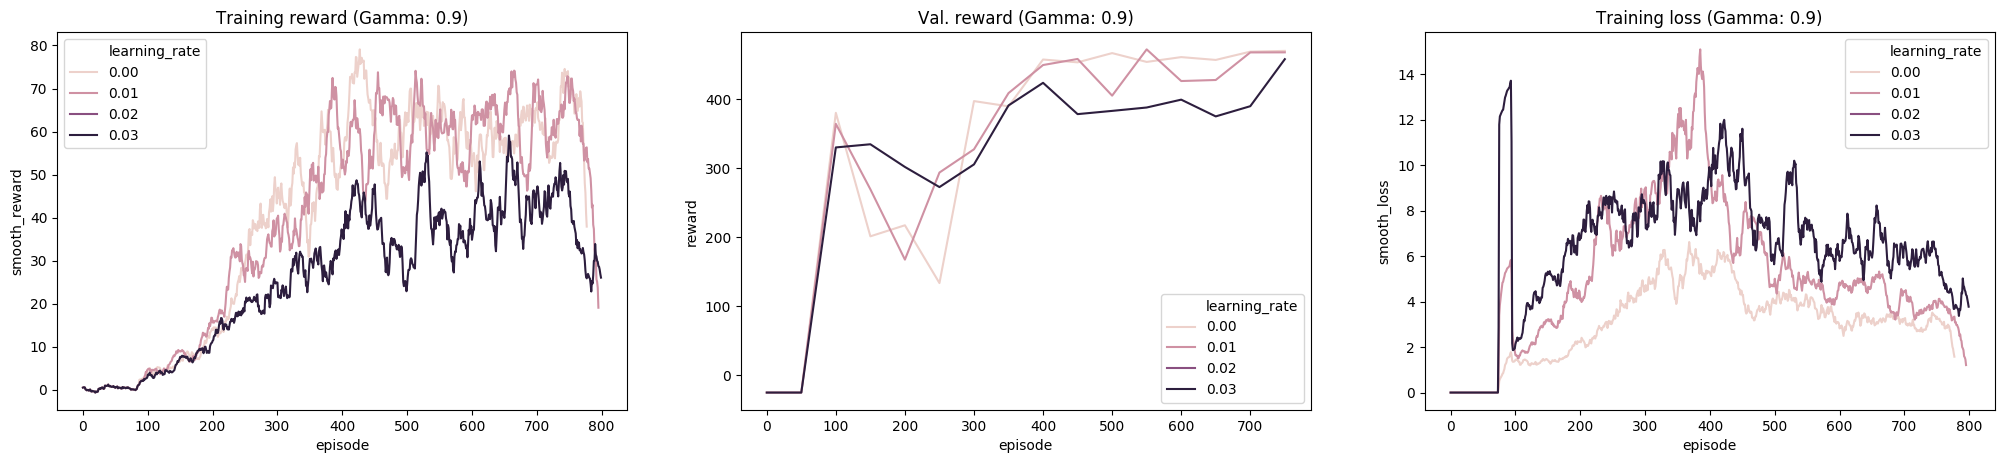

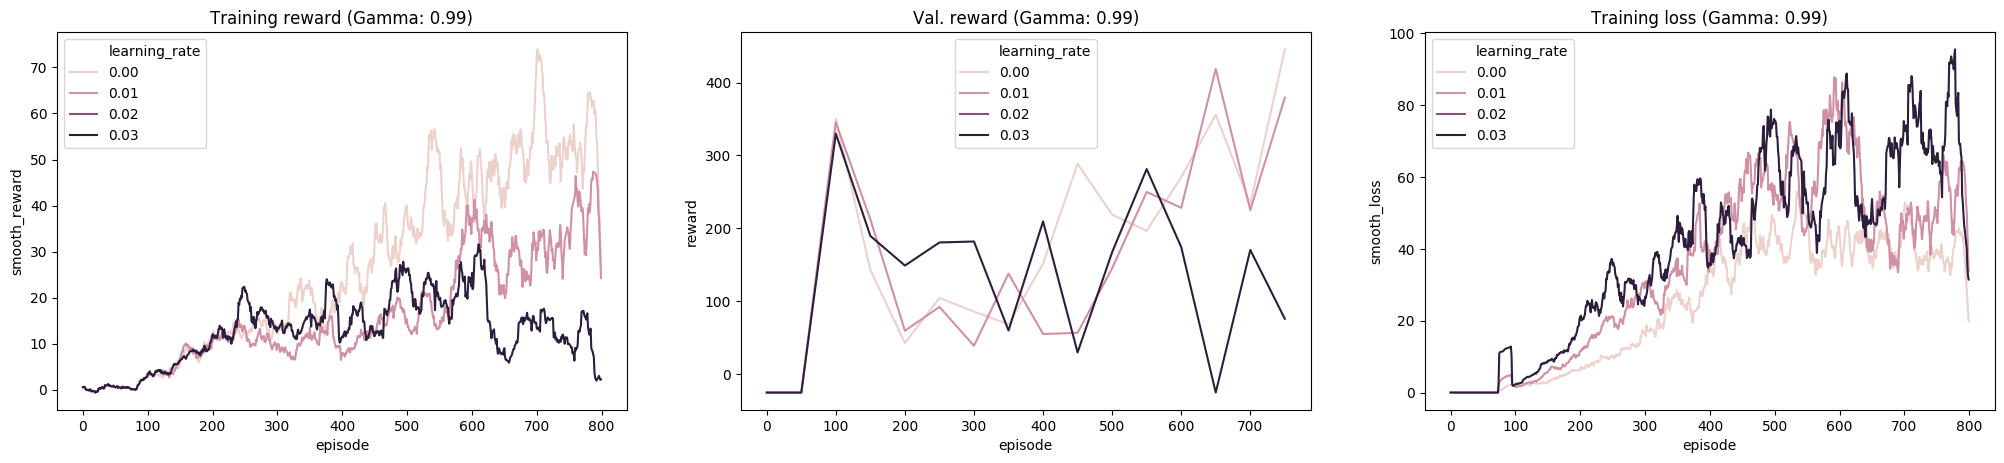

In [19]:
for gamma in GAMMAs:
    data_tr = all_stats.loc[(all_stats.validation==0) & (all_stats.gamma == gamma)]
    data_val = all_stats.loc[(all_stats.validation==1) & (all_stats.gamma == gamma)]
    
    plt.figure(figsize = (25,5),dpi=100)
    plt.subplot(1,3,1)
    sns.lineplot(data=data_tr,x='episode',y='smooth_reward',hue='learning_rate')
    plt.title('Training reward (Gamma: {})'.format(gamma))
    
    plt.subplot(1,3,2)
    sns.lineplot(data=data_val,x='episode',y='reward',hue='learning_rate')
    plt.title('Val. reward (Gamma: {})'.format(gamma))
    
    plt.subplot(1,3,3)
    sns.lineplot(data=data_tr,x='episode',y='smooth_loss',hue='learning_rate')
    plt.title('Training loss (Gamma: {})'.format(gamma))
    
    
    plt.show()

In [20]:
complexity = 'plain'
phosphene_resolution =None
seed = 0

GAMMAs = [0.2, 0.5, 0.9]
LRs = [0.0001, 0.0002, 0.0006]

all_stats = pd.DataFrame()
best_stats = pd.DataFrame()

for i,GAMMA in enumerate(GAMMAs):
    for j,LR_DQN in enumerate(LRs):
        model_name = 'exp1_{}_phos{}_S{}_LR{}_gamma{}'.format(complexity,phosphene_resolution,seed,LR_DQN,GAMMA)
        model_name = model_name.replace('.', '')
        model_name = model_name.replace('+', '')
        model_name = model_name.replace(',', '')
    
        train_stats = pd.read_csv('./Out/Exp0_hyperparameter_testing_1/{}_train_stats.csv'.format(model_name))
        train_stats.loc[train_stats['validation']==0,'smooth_reward']  = np.convolve(train_stats.loc[train_stats.validation==0].reward,np.ones(20)/20,mode='same')
        train_stats.loc[train_stats['validation']==0,'smooth_loss']  = np.convolve(train_stats.loc[train_stats.validation==0].train_loss,np.ones(20)/20,mode='same')

        
        
        train_stats['gamma'] = GAMMA
        train_stats['learning_rate'] = LR_DQN
        train_stats['model_name'] = model_name
        


         # append all rows
        all_stats = all_stats.append(train_stats,ignore_index=True)

        # append only best-performing validation row
        val = train_stats.loc[train_stats.validation==1].reset_index()
        
        
        best_stats = best_stats.append(val.iloc[[val.reward.idxmax()]], ignore_index=True)

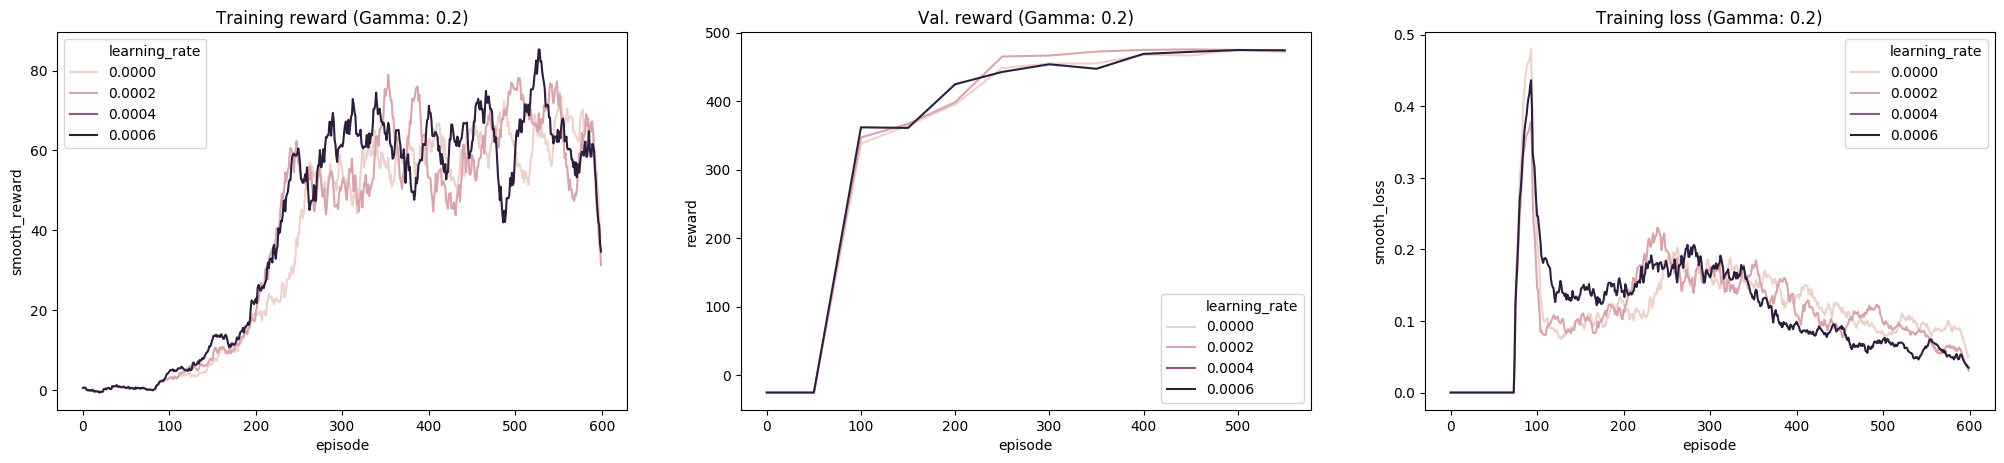

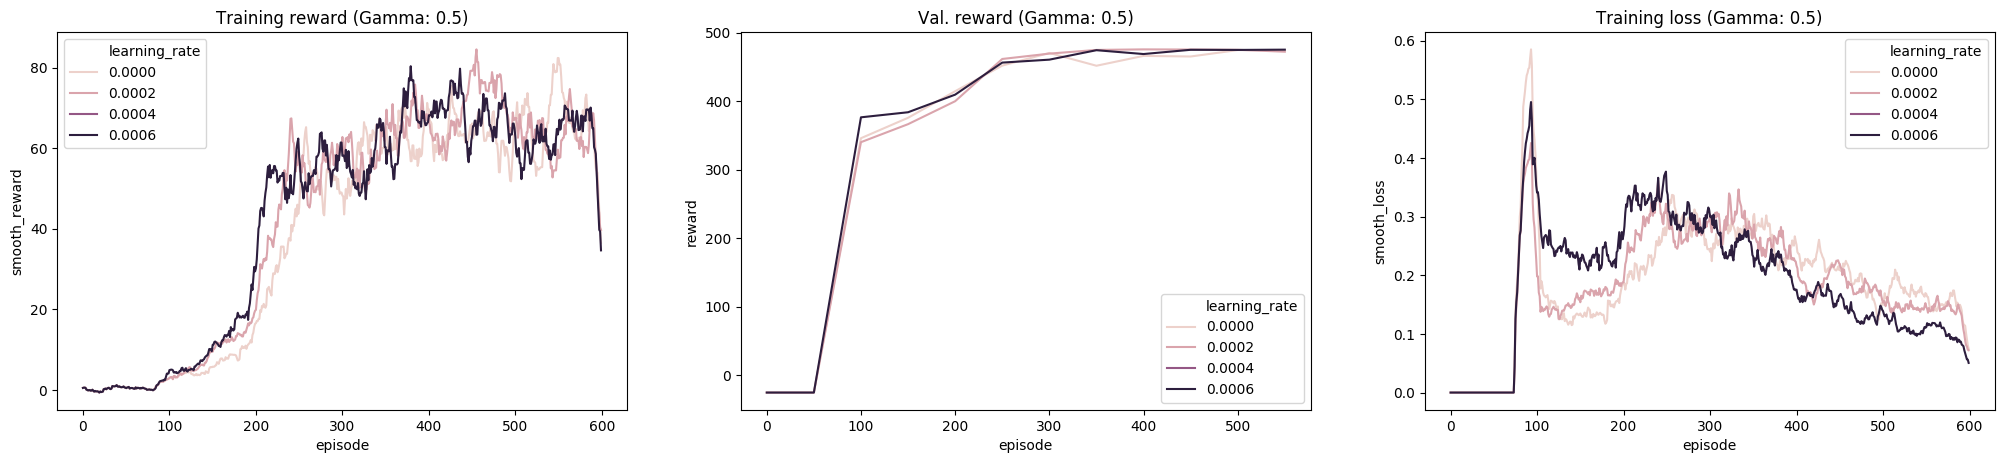

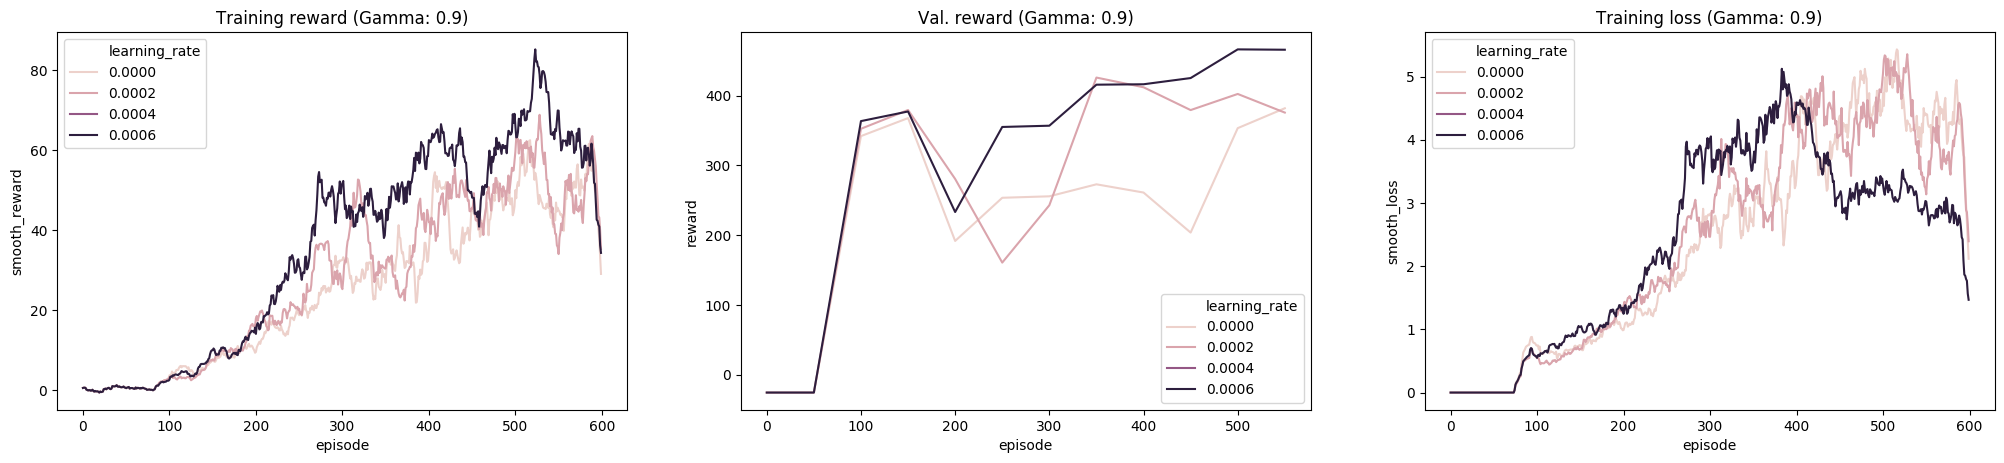

In [21]:
for gamma in GAMMAs:
    data_tr = all_stats.loc[(all_stats.validation==0) & (all_stats.gamma == gamma)]
    data_val = all_stats.loc[(all_stats.validation==1) & (all_stats.gamma == gamma)]
    
    plt.figure(figsize = (25,5),dpi=100)
    plt.subplot(1,3,1)
    sns.lineplot(data=data_tr,x='episode',y='smooth_reward',hue='learning_rate')
    plt.title('Training reward (Gamma: {})'.format(gamma))
    
    plt.subplot(1,3,2)
    sns.lineplot(data=data_val,x='episode',y='reward',hue='learning_rate')
    plt.title('Val. reward (Gamma: {})'.format(gamma))
    
    plt.subplot(1,3,3)
    sns.lineplot(data=data_tr,x='episode',y='smooth_loss',hue='learning_rate')
    plt.title('Training loss (Gamma: {})'.format(gamma))
    
    
    plt.show()

In [23]:
complexity = 'plain'
phosphene_resolution =None
seed = 0

GAMMAs = [0.1, 0.2, 0.5, 0.9, 0.99, 0.999]
LRs = [0.00005, 0.0001, 0.0002, 0.0006, 0.002]

all_stats = pd.DataFrame()
best_stats = pd.DataFrame()

for i,GAMMA in enumerate(GAMMAs):
    for j,LR_DQN in enumerate(LRs):
        model_name = 'exp1_{}_phos{}_S{}_LR{}_gamma{}'.format(complexity,phosphene_resolution,seed,LR_DQN,GAMMA)
        model_name = model_name.replace('.', '')
        model_name = model_name.replace('+', '')
        model_name = model_name.replace(',', '')
    
        train_stats = pd.read_csv('./Out/Exp0_hyperparameter_testing_1/{}_train_stats.csv'.format(model_name))
        train_stats.loc[train_stats['validation']==0,'smooth_reward']  = np.convolve(train_stats.loc[train_stats.validation==0].reward,np.ones(20)/20,mode='same')
        train_stats.loc[train_stats['validation']==0,'smooth_loss']  = np.convolve(train_stats.loc[train_stats.validation==0].train_loss,np.ones(20)/20,mode='same')

        
        
        train_stats['gamma'] = GAMMA
        train_stats['learning_rate'] = LR_DQN
        train_stats['model_name'] = model_name
        


         # append all rows
        all_stats = all_stats.append(train_stats,ignore_index=True)

        # append only best-performing validation row
        val = train_stats.loc[train_stats.validation==1].reset_index()
        
        
        best_stats = best_stats.append(val.iloc[[val.reward.idxmax()]], ignore_index=True)

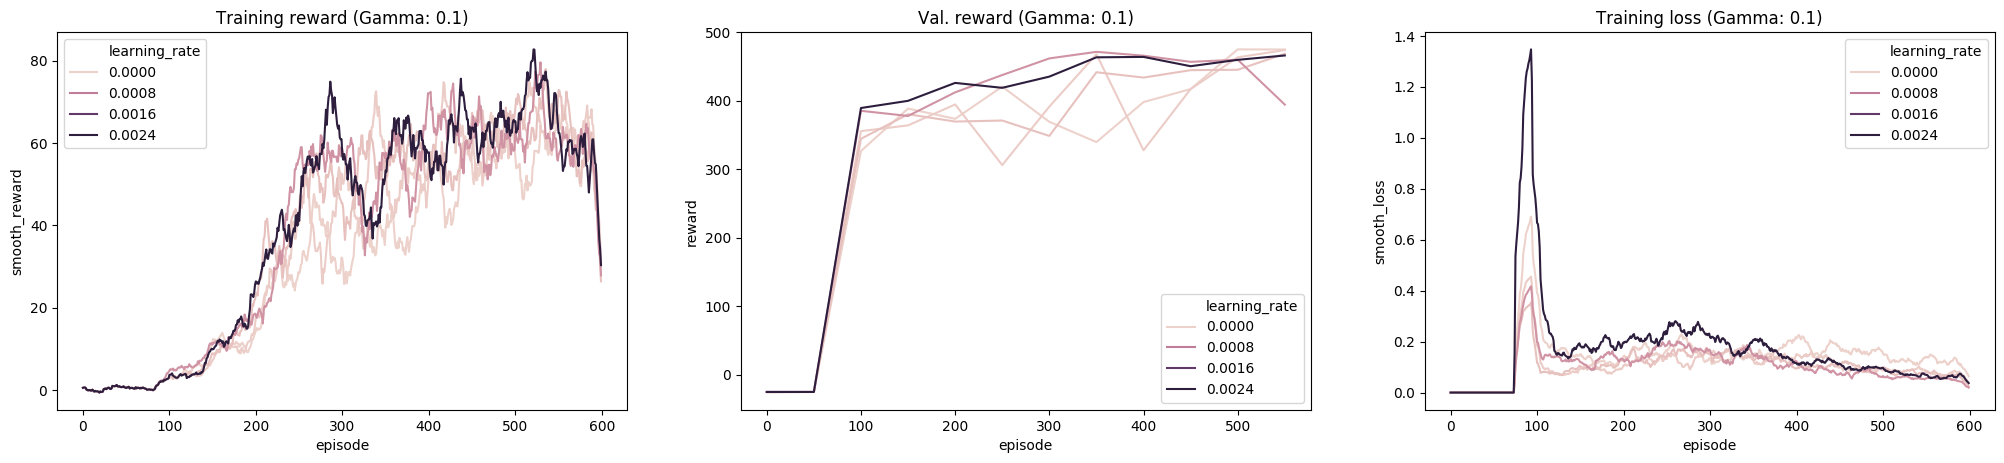

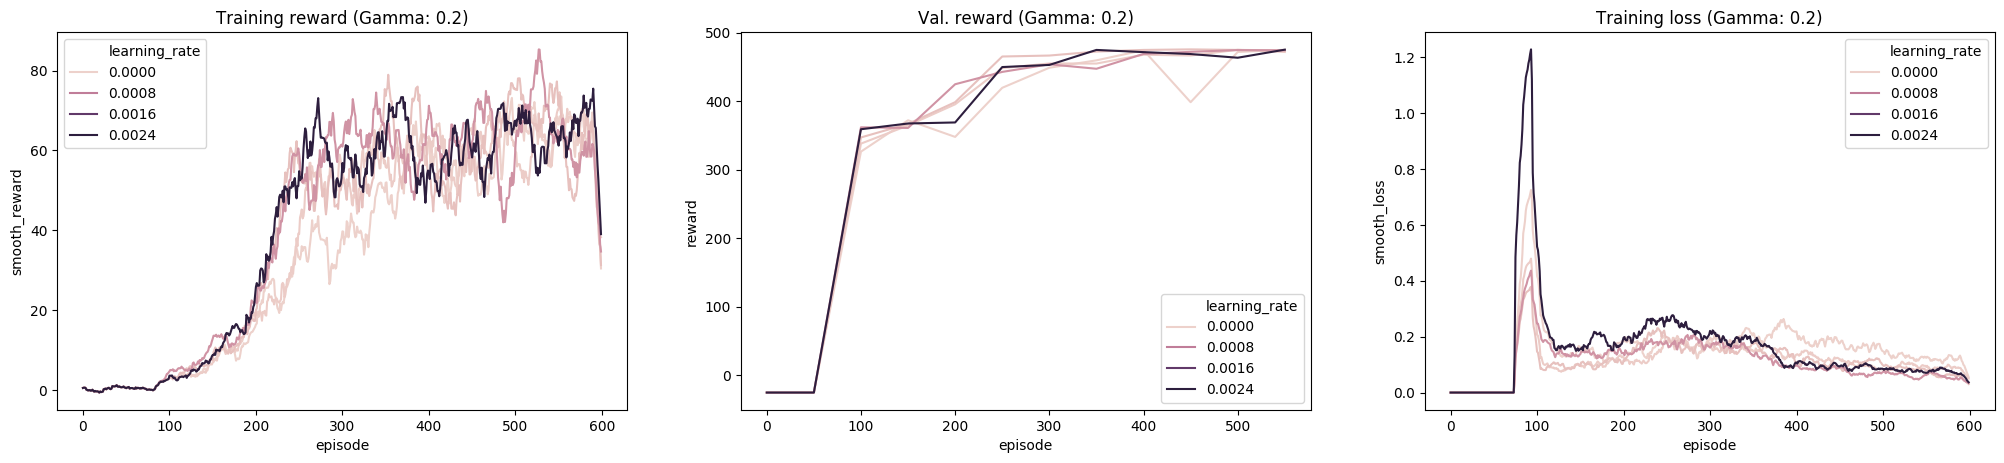

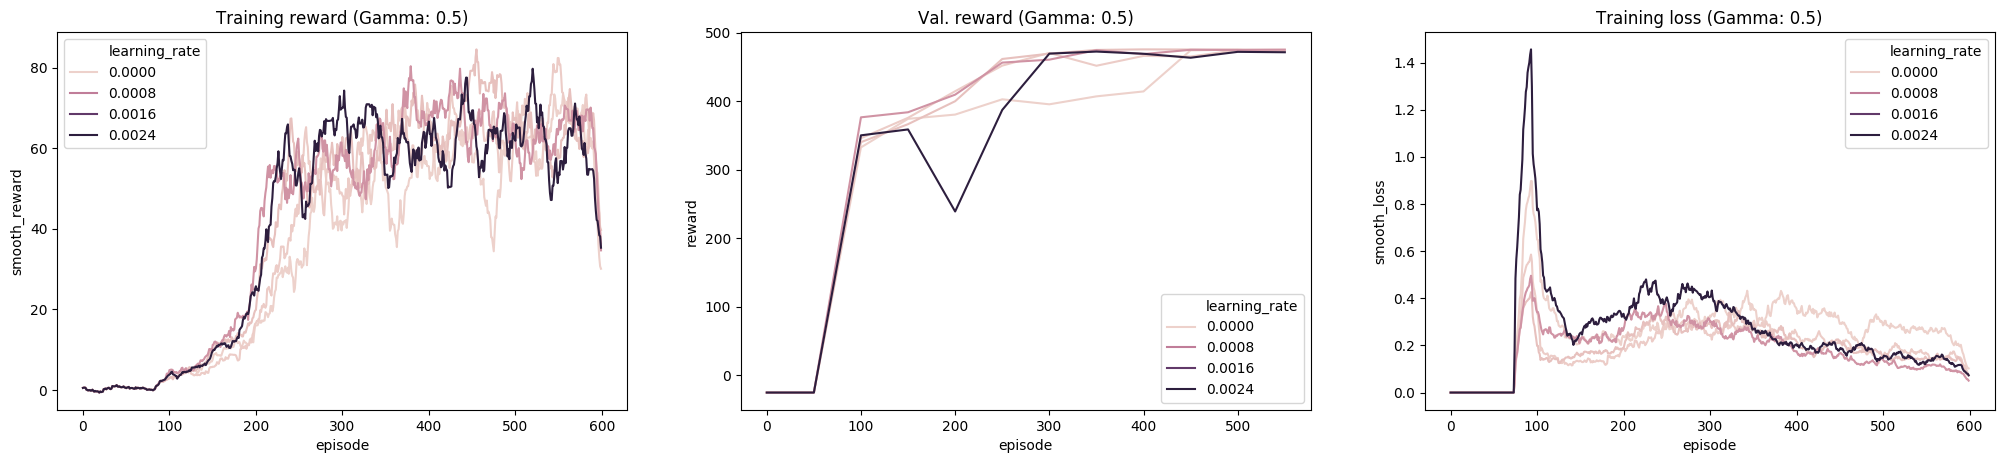

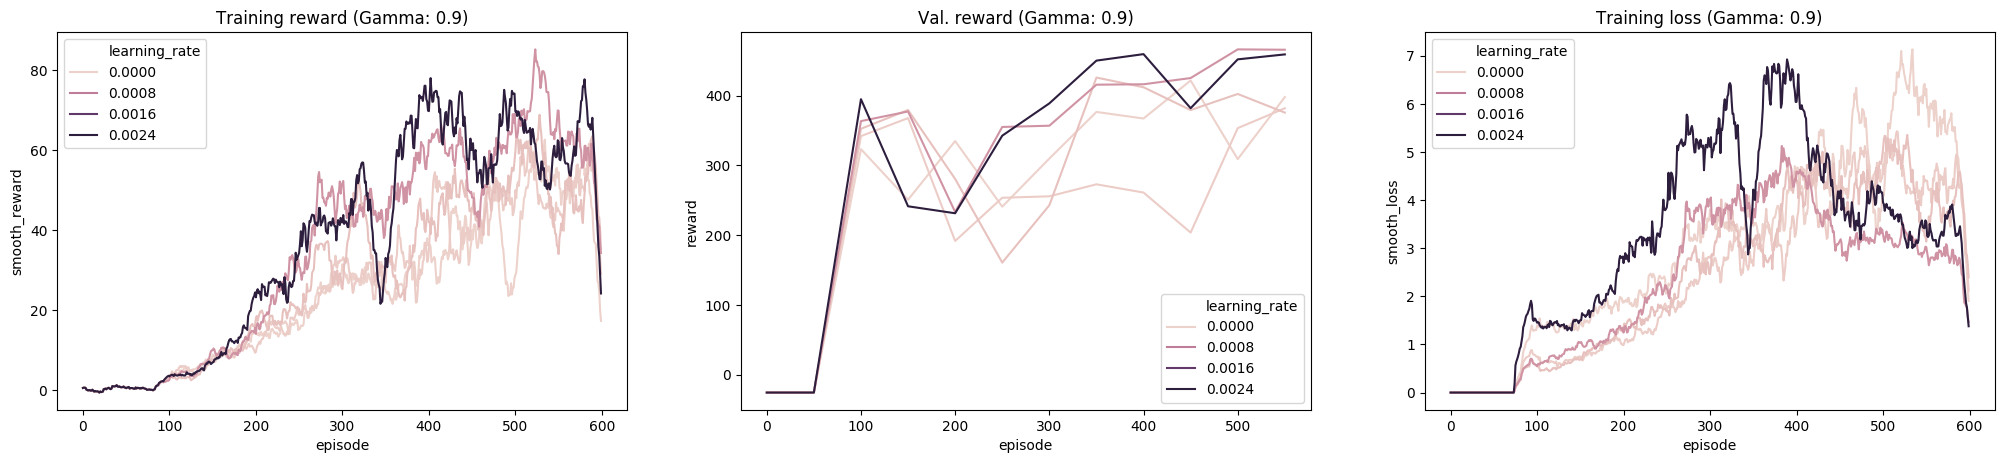

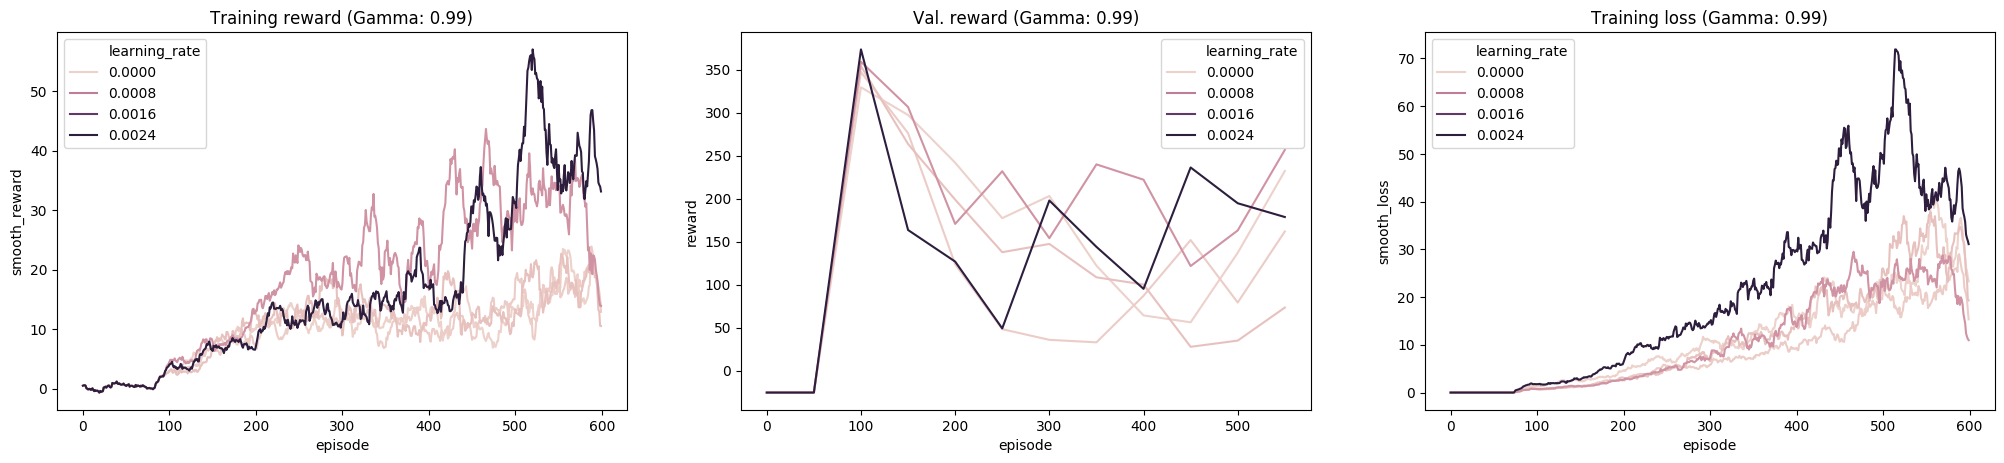

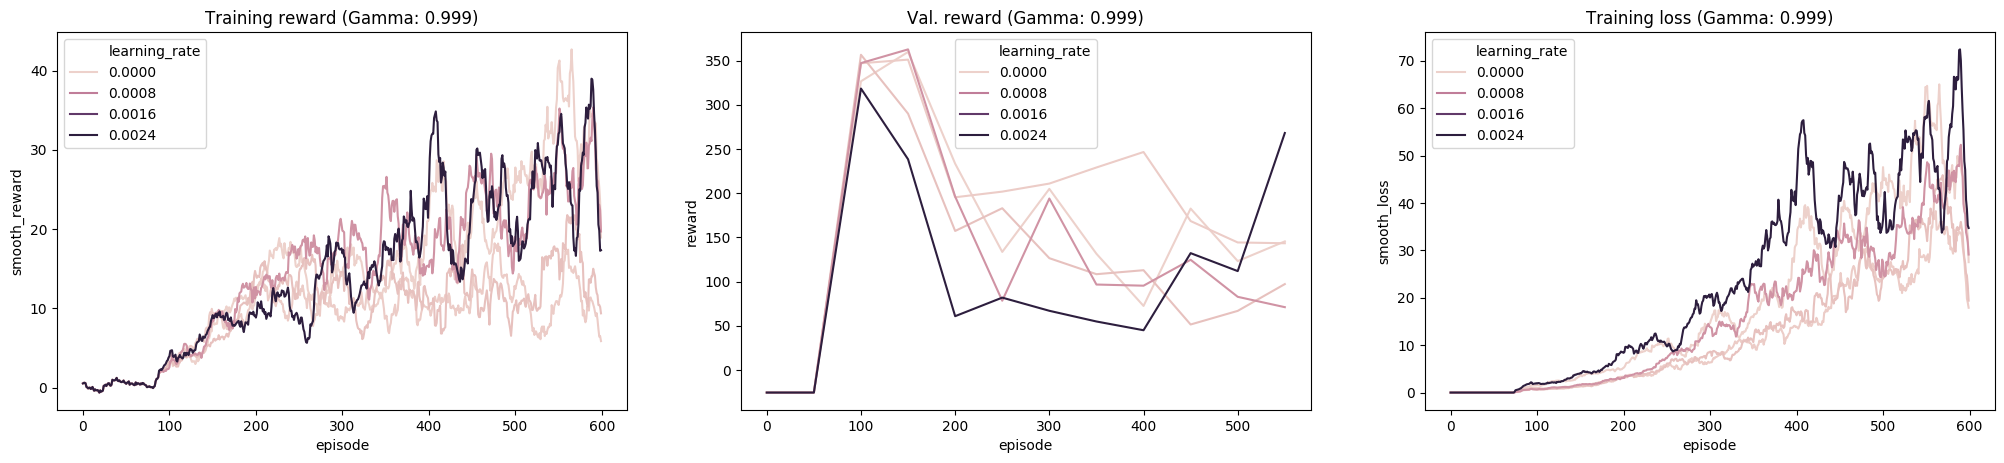

In [24]:
for gamma in GAMMAs:
    data_tr = all_stats.loc[(all_stats.validation==0) & (all_stats.gamma == gamma)]
    data_val = all_stats.loc[(all_stats.validation==1) & (all_stats.gamma == gamma)]
    
    plt.figure(figsize = (25,5),dpi=100)
    plt.subplot(1,3,1)
    sns.lineplot(data=data_tr,x='episode',y='smooth_reward',hue='learning_rate')
    plt.title('Training reward (Gamma: {})'.format(gamma))
    
    plt.subplot(1,3,2)
    sns.lineplot(data=data_val,x='episode',y='reward',hue='learning_rate')
    plt.title('Val. reward (Gamma: {})'.format(gamma))
    
    plt.subplot(1,3,3)
    sns.lineplot(data=data_tr,x='episode',y='smooth_loss',hue='learning_rate')
    plt.title('Training loss (Gamma: {})'.format(gamma))
    
    
    plt.show()